In [13]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import numpy as np
import matplotlib.pyplot as plt
import os.path as path
import wget
import os
from scipy.stats import chi2
from scipy.stats import t
from tqdm import tqdm
import sympy as sym

In [14]:
sample = np.array([0.974,0.950,0.932,1.104,1.038,0.920,0.935,0.907,0.810,0.915])

In [15]:
mean = np.mean(sample)
print(mean)

0.9484999999999999


In [16]:
def Resample(sample):
    
    resample_ = np.random.choice( sample, size = len(sample), replace = True )
    return resample_

In [17]:
np.mean(Resample(sample))

0.9404

In [18]:
def Bootstrapping(sample,N=10000):
    
    Mean_Dist = np.zeros(N)
    
    for i in tqdm(range(N)):
        resample = Resample(sample)
        Mean_Dist[i] = np.mean(resample)
        
    return Mean_Dist

In [31]:
mean = np.percentile(Mean_Dist,50)
print(mean)
q1 = np.quantile( a = Mean_Dist, q=[0.16,0.84] )
q2 = np.quantile( a = Mean_Dist, q=[0.023,0.977] )

q1

0.9478000000000002


array([0.9253, 0.9717])

In [28]:
Mean_Dist = Bootstrapping(sample)

100%|███████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9872.31it/s]


In [30]:
errorinf = mean-q1[0]
errorsup = q1[1] - mean
print(errorinf,errorsup)

0.022800000000000042 0.0239999999999998


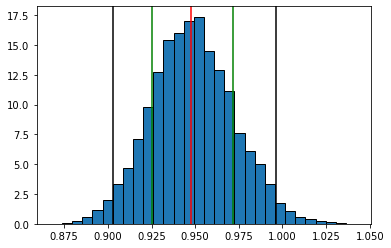

In [32]:
plt.hist(Mean_Dist, bins=30, density=True, ec='k')
plt.axvline(x=mean,color='r')
plt.axvline(x=q1[0],color='g')
plt.axvline(x=q1[1],color='g')
plt.axvline(x=q2[0],color='k')
plt.axvline(x=q2[1],color='k')

$$ \hat{\mu} = 0.948_{0.022}^{0.023}  at 68\% CL $$

In [33]:
# Descargamos data
if not path.exists('Data'):
    os.mkdir('Data')

!rm Data/*

file = 'Data/data.csv'
url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosCuadratico.txt'
#url = 'https://raw.githubusercontent.com/asegura4488/Database/main/MetodosComputacionalesReforma/MinimosLineal.txt'

if not path.exists(file):
    Path_ = wget.download(url,file)
    print('File loaded')
else:
    Path_ = file

100% [..................................................................................] 521 / 521File loaded


In [34]:
Data = np.loadtxt(Path_)

In [35]:
x = Data[:,0]
y = Data[:,1]
N = len(x)
sigma = np.random.uniform(1,4,size=N)
sigma

array([2.21198596, 3.355882  , 2.34011068, 3.6114421 , 2.07465232,
       3.4056553 , 2.99919761, 3.38692934, 2.41577188, 3.83952771,
       2.83041381, 3.13989793, 2.60799039, 1.851381  , 2.44361594,
       2.53250185, 2.24872718, 3.66662038, 2.72686513, 1.93753066])

In [36]:
def GetFit(x,y,n=3):
    
    size = len(x)
    b = y
    
    A = np.ones((size,n+1))
    
    for i in range(1,n+1):
        A[:,i] = x**(i)

    # Hacer ajuste cuadratico
    
    M = np.dot(A.T,A)
    bt = np.dot(A.T,b)
    
    xsol = np.linalg.solve(M,bt)

    return xsol

In [37]:
n = 2 # order of the polynomial
param = GetFit(x,y,n=n)
print(param)

[1.22132054 6.09075205 2.9565874 ]


In [38]:
def GetModel(x,p):
    
    y = 0.
    for i in range(len(p)):
        y += p[i]*x**i
    
    return y

In [39]:
X = sym.Symbol('x',real=True)
GetModel(X,param)

2.95658740177385*x**2 + 6.0907520463624*x + 1.2213205361703

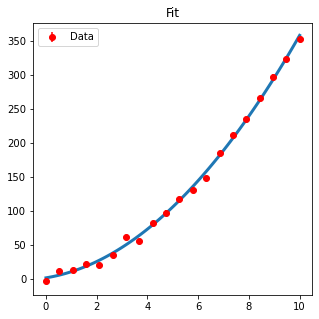

In [40]:
t = np.linspace(np.min(x),np.max(x),100)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.errorbar(x,y,yerr=sigma,fmt='o',color='r',label='Data')
ax.set_title('Fit')
ax.plot(t,GetModel(t,param),lw=3) 
#ax.plot(t,GetModel(t,param), label="Parameters: {0}".format(np.round(param,2))) 
ax.legend(loc=0)

In [41]:
def GetChi2(x,y,sigma,p,reducido=True):
    
    df = (len(x) - len(p) - 1) 
    
    if not reducido:
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) , df
    else:   
        return np.sum( ( ( y - GetModel(x,p) )/sigma )**2 ) / df ,df

In [42]:
param = GetFit(x,y,n)
Chi2,df = GetChi2(x,y,sigma,param)
print(Chi2)

4.9150060986671695


# Bootstraping

In [44]:
dict1 = dict(zip(x,y))
#dict1

In [45]:
def GetBootstrapping(x,n=3,Ntrials=int(3e4)):
    
    Values = np.zeros( (Ntrials, n+1) )
    
    for i in tqdm(range(Ntrials)):
        
        x1 = Resample(x)
        
        y1 = np.array([])
        
        for j in x1:
            y1 = np.append(y1,dict1[j])
            
        p = GetFit(x1,y1,n)
        
        Values[i] = p
        
    return Values

In [53]:
Mean_Dist = GetBootstrapping(x,n=3)

100%|███████████████████████████████████████████████████████| 30000/30000 [00:16<00:00, 1802.06it/s]


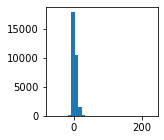

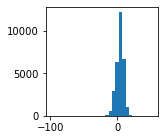

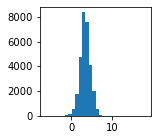

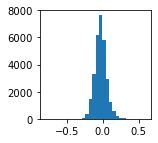

In [55]:
for i in range(3+1):
    fig = plt.figure(figsize=(2,2))
    plt.hist( Mean_Dist[:,i], bins=30 )

In [56]:
mean = np.percentile(Mean_Dist, 50, axis=0 )
mean

array([ 2.32444461,  4.23567934,  3.44283212, -0.03269876])

In [57]:
q1 = np.quantile( a = Mean_Dist, q=[0.16,0.84], axis=0 )
q1

array([[-1.32792306, -1.75206167,  2.33588801, -0.105898  ],
       [10.26781238,  8.52130304,  4.67688183,  0.0438459 ]])

In [58]:
errorsup = q1[1] - mean
errorinf = mean - q1[0]
print(errorsup)
print(errorinf)

[7.94336777 4.28562369 1.23404971 0.07654467]
[3.65236768 5.98774101 1.10694411 0.07319924]
